In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.pipeline import make_pipeline

from library.sb_utils import save_file

In [28]:
#Import traning and test sets from preprocessing

datapath = "../data/"
X_train = np.genfromtxt(datapath+"X_train.csv", delimiter=',')
X_test = np.genfromtxt(datapath+"X_test.csv", delimiter=',')
y_train = np.genfromtxt(datapath+"y_train.csv", delimiter=',')
y_test = np.genfromtxt(datapath+"y_test.csv", delimiter=',')
columns = np.genfromtxt(datapath+"columns.csv", delimiter=',', dtype=None, encoding='utf-8')

In [3]:
#Model 0: Assess performance when all tests come back positive (M=1)
from sklearn.dummy import DummyClassifier

dum_class = DummyClassifier(strategy='constant', constant=1)
dum_class.fit(X_train, y_train)
y_pred_0 = dum_class.predict(X_test)

Precision score 0.3742690058479532
Recall score  1.0


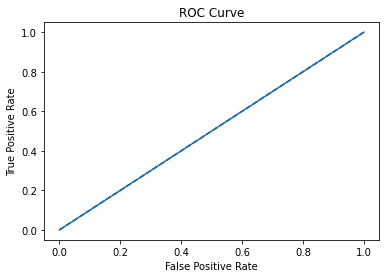

ROC-AUC score : 0.5


In [4]:
#Scoring the model
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

print('Precision score', metrics.precision_score(y_test,y_pred_0))
print('Recall score ', metrics.recall_score(y_test,y_pred_0))
y_pred_prob = dum_class.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print("ROC-AUC score :", roc_auc_score(y_test, y_pred_0))

The purpose of this model is to establish a baseline of randomly guessing that all tests are positive for cancer. The precision score - the proportion of true malignant predictions over all malignant predictions - is about 0.37, which corresponds to the proportion of the tests in the dataset that were classified as malignant. This obviously means that this "model" would over-diagnose over 60% of all tests, which would mean unnecessary intervention, expense, and worry. 


The recall score - the proportion of true malignant predictions over all malignant malignant diagnoses - is 1.0, which makes sense given that all tests were predicted as true. In other words, this model would not miss any tests where malignant cells were present, as it assumes they are all malignant. 

Finally, the ROC-AUC is 0.5, which is associated with randomly guessing. 

This serves as a benchmark through which I will evaluate my modeling efforts. A model that doesn't over diagnose cancer but still doesn't miss cancer is the goal.

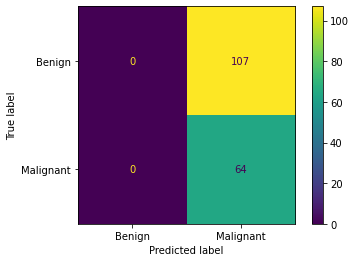

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       107
         1.0       0.37      1.00      0.54        64

    accuracy                           0.37       171
   macro avg       0.19      0.50      0.27       171
weighted avg       0.14      0.37      0.20       171



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [5]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_0)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
disp.plot()
plt.show()
print(classification_report(y_test, y_pred_0))

In [39]:
#Model 1: Logistic Regression
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=0.1, random_state=10001)
clf.fit(X_train, y_train)
y_pred_1 = clf.predict(X_test)



Precision score 1.0
Recall score  0.953125


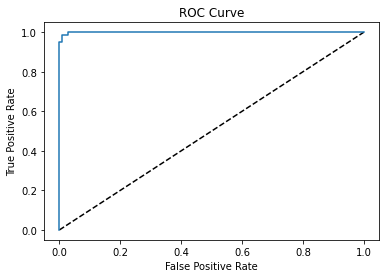

ROC-AUC score : 0.9765625


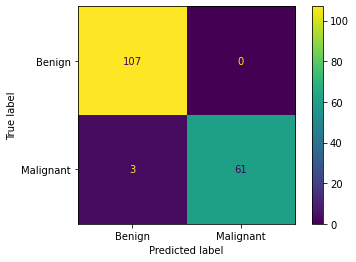

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       107
         1.0       0.37      1.00      0.54        64

    accuracy                           0.37       171
   macro avg       0.19      0.50      0.27       171
weighted avg       0.14      0.37      0.20       171



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
print('Precision score', metrics.precision_score(y_test,y_pred_1))
print('Recall score ', metrics.recall_score(y_test,y_pred_1))
y_pred_prob = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print("ROC-AUC score :", roc_auc_score(y_test, y_pred_1))

cm = confusion_matrix(y_test, y_pred_1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
disp.plot()
plt.show()
print(classification_report(y_test, y_pred_0))

That looks wonderful, doesn't it? It's also clearly wrong. I have not done any feature selection, so some features are arbitrarily weighted. We need to do more judicial feature selection, as I believe this is overfit.

In [64]:
#Manual Feature selection
#radius_mean, perimeter_mean, area_mean: area_mean
#radius_se, perimeter_se, area_se: area_se
#radius_worst, perimeter_worst, area_worst: area_worst
#note that this is somewhat arbitrary, as there are still some highly (over 0.9) correlated features

X_train_df = pd.DataFrame(X_train, columns=columns)
X_test_df = pd.DataFrame(X_test, columns=columns)

dropfeatures = ['radius_mean', 'perimeter_mean', 'radius_se', 'perimeter_se', 'radius_worst','perimeter_worst']

X_train_select = X_train_df.drop(columns=dropfeatures)
X_test_select = X_test_df.drop(columns=dropfeatures)



Precision score 1.0
Recall score  0.96875


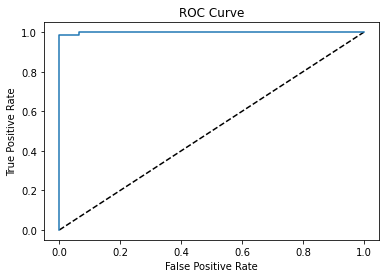

ROC-AUC score : 0.984375


In [65]:
clf = LogisticRegression(C=0.1, random_state=10001)
clf.fit(X_train_select, y_train)
y_pred_1 = clf.predict(X_test_select)

print('Precision score', metrics.precision_score(y_test,y_pred_1))
print('Recall score ', metrics.recall_score(y_test,y_pred_1))
y_pred_prob = clf.predict_proba(X_test_select)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print("ROC-AUC score :", roc_auc_score(y_test, y_pred_1))

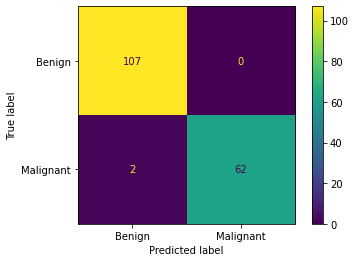

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       107
         1.0       1.00      0.97      0.98        64

    accuracy                           0.99       171
   macro avg       0.99      0.98      0.99       171
weighted avg       0.99      0.99      0.99       171



In [66]:
cm = confusion_matrix(y_test, y_pred_1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
disp.plot()
plt.show()
print(classification_report(y_test, y_pred_1))

In [67]:



from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import f1_score

pipe = make_pipeline(
    SelectKBest(f_classif),
    LogisticRegression()
)



In [68]:
k = [k+1 for k in range(X_train_select.shape[1])]
grid_params = {'selectkbest__k': k}
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)
lr_grid_cv.fit(X_train_select, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selectkbest', SelectKBest()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24]})

Precision score 0.984375
Recall score  0.984375


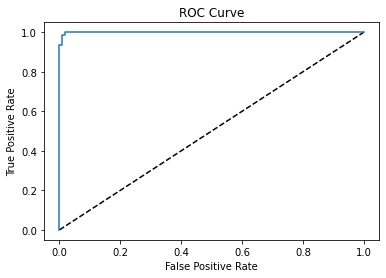

ROC-AUC score : 0.9875146028037384


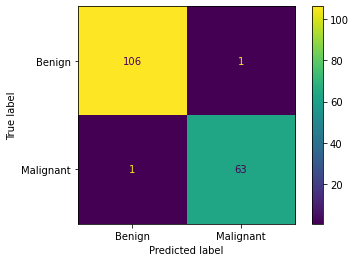

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       107
         1.0       0.98      0.98      0.98        64

    accuracy                           0.99       171
   macro avg       0.99      0.99      0.99       171
weighted avg       0.99      0.99      0.99       171

Index(['area_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'area_se', 'concave points_se', 'texture_worst',
       'area_worst', 'smoothness_worst', 'compactness_worst',
       'concavity_worst', 'concave points_worst', 'symmetry_worst'],
      dtype='object')


In [77]:
y_pred_1 = lr_grid_cv.predict(X_test_select)
print('Precision score', metrics.precision_score(y_test,y_pred_1))
print('Recall score ', metrics.recall_score(y_test,y_pred_1))
y_pred_prob = lr_grid_cv.predict_proba(X_test_select)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print("ROC-AUC score :", roc_auc_score(y_test, y_pred_1))
cm = confusion_matrix(y_test, y_pred_1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
disp.plot()
plt.show()
print(classification_report(y_test, y_pred_1))

selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

print(X_train_select.columns[selected])

In [80]:
#Model 2: KNN
from sklearn.neighbors import KNeighborsClassifier

klist = np.arange(0,11)
knn = KNeighborsClassifier(random_state=42)
grid_params = {'n_neighbors': klist}
knn_grid_cv = GridSearchCV(knn, param_grid=grid_params, cv=5, n_jobs=-1)
knn_grid_cv.fit(X_train_select, y_train)
y_pred_2 = knn_grid_cv.predict(X_test_select)

TypeError: __init__() got an unexpected keyword argument 'random_state'

Precision score 0.9264705882352942
Recall score  0.984375


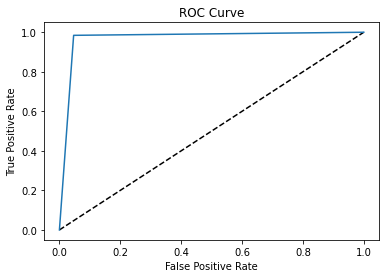

ROC-AUC score : 0.9688230140186916


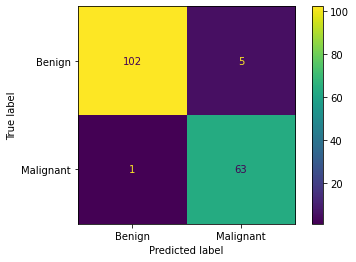

              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97       107
         1.0       0.93      0.98      0.95        64

    accuracy                           0.96       171
   macro avg       0.96      0.97      0.96       171
weighted avg       0.97      0.96      0.97       171



In [81]:
print('Precision score', metrics.precision_score(y_test,y_pred_2))
print('Recall score ', metrics.recall_score(y_test,y_pred_2))
y_pred_prob = knn_grid_cv.predict_proba(X_test_select)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print("ROC-AUC score :", roc_auc_score(y_test, y_pred_2))
cm = confusion_matrix(y_test, y_pred_2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
disp.plot()
plt.show()
print(classification_report(y_test, y_pred_2))

In [ ]:
#Model 3: SVM
from sklearn.svm import SVC

svm = SVC()

In [ ]:
#Model 4: Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

In [ ]:
#PCA versions of 1-4
from sklearn.decomposition import PCA

pca = PCA()


In [ ]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
#import lightgbm
from bayes_opt import BayesianOptimization
from catboost import CatBoostClassifier, cv, Pool



In [ ]:
#Define Bayesian function that we wish to maximize

def clf_eval(num_leaves,max_depth,lambda_l2,lambda_l1,min_child_samples, min_data_in_leaf):
    params = {
        "objective" : "binary",
        "metric" : "auc", 
        'is_unbalance': True,
        "num_leaves" : int(num_leaves),
        "max_depth" : int(max_depth),
        "lambda_l2" : lambda_l2,
        "lambda_l1" : lambda_l1,
        "num_threads" : 20,
        "min_child_samples" : int(min_child_samples),
        'min_data_in_leaf': int(min_data_in_leaf),
        "learning_rate" : 0.03,
        "subsample_freq" : 5,
        "bagging_seed" : 42,
        "verbosity" : -1
    }